In [12]:
import numpy as np
import scipy as scp
from pyedflib import highlevel
import pyedflib as plib
import matplotlib.pyplot as plt
import mne as mne
from scipy import linalg as la
from sklearn.linear_model import Perceptron
from sklearn.cluster import AffinityPropagation
import os

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pickle

In [13]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


#subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
subfolders, datafiles = run_fast_scandir('../dataset/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])

['../dataset/files\\S001', '../dataset/files\\S002', '../dataset/files\\S003']
['../dataset/files\\S001\\S001R01.edf', '../dataset/files\\S001\\S001R02.edf', '../dataset/files\\S001\\S001R03.edf']


<h1>Criação do filter bank - próximos 2 blocos</h1>

In [14]:
min_freq = 4
max_freq = 40

n_bands = int((max_freq - min_freq)/2)

bands = []
f1 = 4
f2 = 8

for i in range(1,n_bands):
  bands.append([f1,f2])
  f1+=2
  f2+=2
print("Bandas de frequência: ", bands)

Bandas de frequência:  [[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


In [15]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

for band in bands:

  filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=band[0], h_freq=band[1], fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
  #mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.5, 60)) # Plot do filtro

mne.set_log_level('WARNING')

Extracting EDF parameters from f:\OneDrive\Ambiente de Trabalho\neuro\eegaming\dataset\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 529 samples (3.306 s)

Setting up band-pass filter from 6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 1

In [16]:
def check_event_count(event_data):

  '''
  Função que:
  - Faz prints do número de trials/blocos de cada classe de movimento. 

  ---------------------
  Input:
  - event_data: Objeto com todos os blocos de dados

  '''

  print("Rest: ", event_data["rest"].__len__())
  print("Right Fist: ", event_data["right_fist"].__len__())
  print("Left Fist: ", event_data["left_fist"].__len__())
  print("Both Fists: ", event_data["both_fists"].__len__())
  print("Both Feet: ", event_data["both_feet"].__len__())
     

''' Commit "Test/Train split: 84144ec" tem todo o código com os prints e plots desta função relacionados com os eventos'''

def load_subject_data(subject, datafiles, bands, tstart, tstop):

  '''
  Função que:
  - Carrega todos os dados contínuos de um participante da base de dados.
  - Filtra os dados contínuos.
  - Reatribui as labels para separar melhor as 5 classes de EEG da base de dados.
  - Agrupa e concatena os blocos dados dos vários trials (bloco com cerca de 4.2s de dados que 
  corresponde à execução de uma classe de movimento) de ficheiros 
  diferentes a partir das novas labels.
  - Segmenta os dados 

  ---------------------
  Input:
  subject: Caminho para o diretório onde estão todos os ficheiros de um participante 
  datafiles: Caminhos de todos os ficheiros edf (todos os participantes) da base de dados
  tstart: Instante no tempo (s) da primeira amostra do segmento de um bloco a ser analisado
  tstop: Instante no tempo (s) da última amostra do segmento de um bloco a ser analisado
  
  ---------------------
  Output:
  subject_epochs: Objeto com todos os blocos de dados concatenados e com toda a informção relativamente
  aos eventos de cada classe
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)

  eachBand_epochs = []
  
  for band in bands: # Filtrar os dados nas várias bandas de frequência
    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    all_trials = [] # Variável com todos os blocos
    
    for count, trial  in enumerate(trials):
      if count > 1: # Avança os dois primeiros trials correspondentes ao rest
        raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
        
        ch_names = raw_data.ch_names # Elétrodos
        fs =  raw_data.info.get('sfreq') # Frequência de amostragem
        annotations = raw_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados

        trial_type1 = [3, 4, 7, 8, 11, 12]
        trial_type2 = [5, 6, 9, 10, 13, 14]

        # Atribuição das labels corretas aos eventos de cada trial
        #--------------- TOMÁS: tive de adaptar a linha seguinte por causa da maneira como tenho o diretório (../ yada yada, cria uma separação para cada ponto,
        # então fica algo tipo [''] [''] ['actual diretorio'] ['edf']) -----------------------------------------
        trial_number = int(trial.split('.')[2][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
        
        if trial_number in trial_type1:
          event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
          epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
        elif trial_number in trial_type2:
          event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
          epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
        else:
          event_ids = {'T0': 1} # Dois primeiros trials de EEG

        # Filtragem

        filtered_data = raw_data.copy().filter(band[0], band[1], fir_design=filter_design, skip_by_annotation=ska) 
        
        # Mapeamento dos eventos com as novas labels

        events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
        
        # Agrupamento dos blocos do mesmo id (epoching)

        epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
        
        all_trials.append(epochs)
        
    # Concatenação de todos os blocos (trials) de uma banda de frequências

    subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
    equalized_subject_epochs = subject_epochs.equalize_event_counts()[0]

    eachBand_epochs.append(equalized_subject_epochs)
    
  return eachBand_epochs

In [17]:
# Carregar dados de todos os participantes
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# O bom balanceamento de classes é importante durante a classificação

mne.set_log_level('CRITICAL')

all_subject_epochs = []

LOAD_FITLERED_FROM_FILES = True

if LOAD_FITLERED_FROM_FILES:
  for id, subject in enumerate(subfolders[40:45]):
    print("---------------------------------------------")
    print("Ler dados do participante: ", id+1)
    with open("..\\filtered_data\\saved_file"+subject.split('\\')[-1]+".pkl", 'rb') as f:
      all_subject_epochs.append(pickle.load(f))


else:
  for id, subject in enumerate(subfolders):
    print("---------------------------------------------")
    print("Ler dados do participante: ", id+1)
    folder_data = load_subject_data(subject, datafiles, bands, 0.5, 3)
    with open("..\\filtered_data\\saved_file"+subject.split('\\')[-1]+".pkl", 'wb') as f:
      pickle.dump(folder_data, f)

    all_subject_epochs.append(folder_data)

  mne.set_log_level('WARNING')

---------------------------------------------
Ler dados do participante:  1
---------------------------------------------
Ler dados do participante:  2
---------------------------------------------
Ler dados do participante:  3
---------------------------------------------
Ler dados do participante:  4
---------------------------------------------
Ler dados do participante:  5


<h1>Exemplo de handling destes dados


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
Indices:  [31 33 35  1  3  5  8 10 12 15 17 19 48 50 52 61]
Condições:  {'rest/block': 1, 'left_fist/block': 2, 'right_fist/block': 3, 'both_fists/block': 4, 'both_feet/block': 5}

Blocos:  [[   672      0      3]
 [  1328      0      1]
 [  1984      0      2]
 [  3296      0      2]
 [  4608      0      3]
 [  5264      0      1]
 [  5920      0      2]
 [  7232      0      3]
 [  7

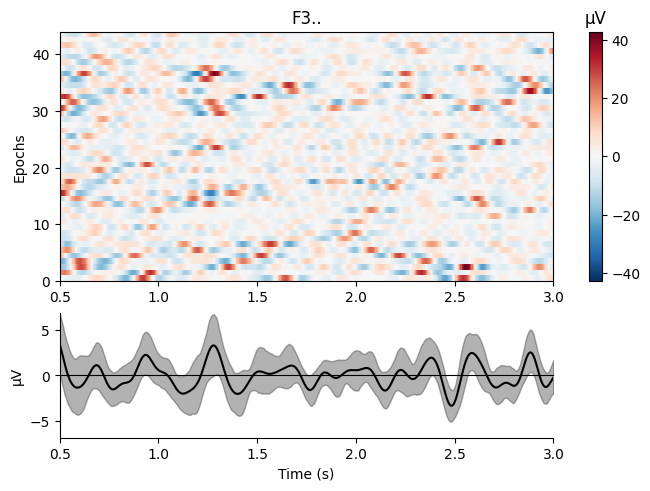

[<Figure size 640x480 with 3 Axes>]

In [18]:
subject_epochs = all_subject_epochs[0][0]

print("\nEqualização de eventos: ")
check_event_count(subject_epochs)
print("\n")

# Seleção de elétrodos
print(channels)
chan = mne.pick_channels(channels, include = ['F3..', 'Fz..','F4..', 
                                              'Fc3.', 'Fcz.','Fc4.',
                                                'C3..','Cz..','C4..',
                                                'Cp3.', 'Cpz.', 'Cp4.',
                                                'P3..', 'Pz..', 'P4..',
                                                'Oz..' ])
print("Indices: ", chan)

#dir(subject_epochs)
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])

<h2> Função que vem a seguir, antes do csp, avalia se achas necessario/ se da jeito

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  # print("Nº de trials: ", n_trials)
  # print("Nº de trials para treinar (por classe): ", n_train)
  # print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  #shuffle trials. O miguel nao fazia. N sei se é sposto n fazer. o on missmatch com raise avisa que n esta por ordem cronologica
  np.random.seed(42)
  ids = np.random.permutation(n_trials//len(classes))
  ids_train = ids[:n_train]
  ids_test = ids[n_train:n_train+n_test]

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][ids_train]._data)
    epochs_test.append(subject_EEG[class_key][ids_test]._data)

  #conver to numpy array
  epochs_train = np.array(epochs_train)
  epochs_test = np.array(epochs_test)

  #filter only channels of interest
  epochs_train = epochs_train[:, :, chan, :]
  epochs_test = epochs_test[:, :, chan, :]
  
  print("Shape dos dados de treino: ", epochs_train.shape)
  print("Shape dos dados de teste: ", epochs_test.shape)

  return epochs_train, epochs_test

# Split Test/Train

classes = subject_epochs.event_id

all_train_data = []
all_test_data = []

for subject in range(len(all_subject_epochs)):

  bands_train_data = []
  bands_test_data = []
  print("Sujeito: ", subject+1)

  for band in range(len(bands)):
    train_data, test_data = split_EEG(all_subject_epochs[subject][band], classes, percent_train=0.8)
    bands_train_data.append(train_data)
    bands_test_data.append(test_data)

  all_train_data.append(bands_train_data)
  all_test_data.append(bands_test_data)

# all_train_data = np.array(all_train_data)
# all_test_data = np.array(all_test_data)

# print("Shape final dos dados de treino: ", all_train_data.shape)
# print("Shape final dos dados de teste: ", all_test_data.shape)

Sujeito:  1
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de treino:  (5, 35, 16, 401)
Shape dos dados de teste:  (5, 9, 16, 401)
Shape dos dados de t

In [21]:
print(np.array(all_train_data).shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (5, 17, 5) + inhomogeneous part.

Sujeito:  1
Banda:  1


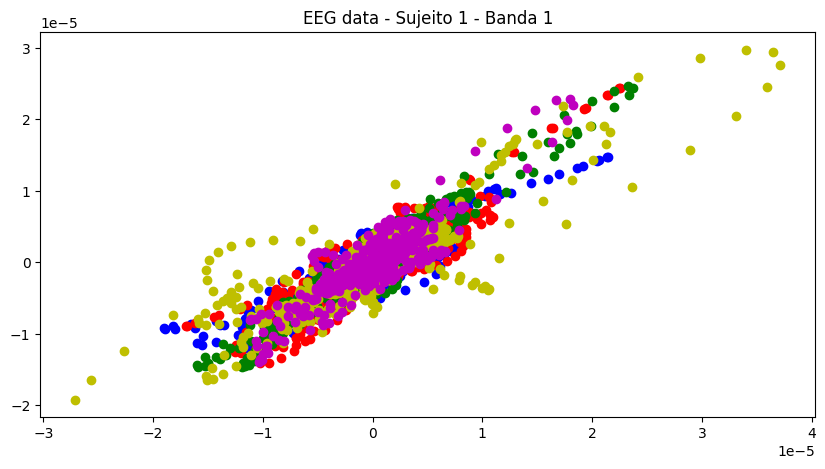

Banda:  2


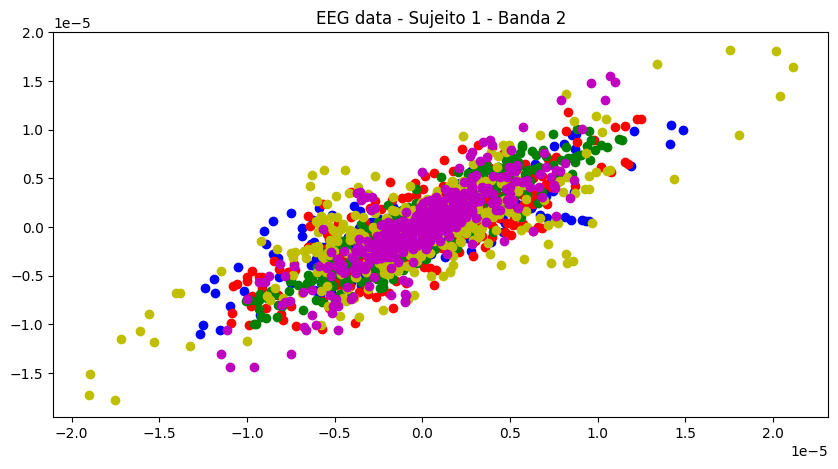

Banda:  3


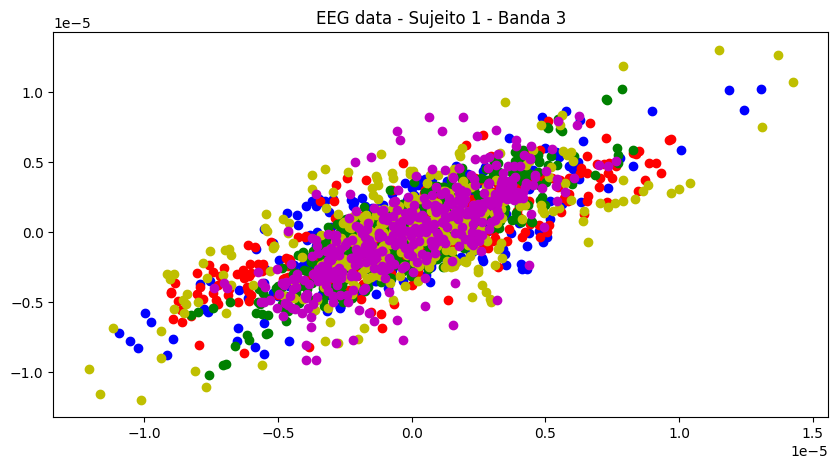

Banda:  4


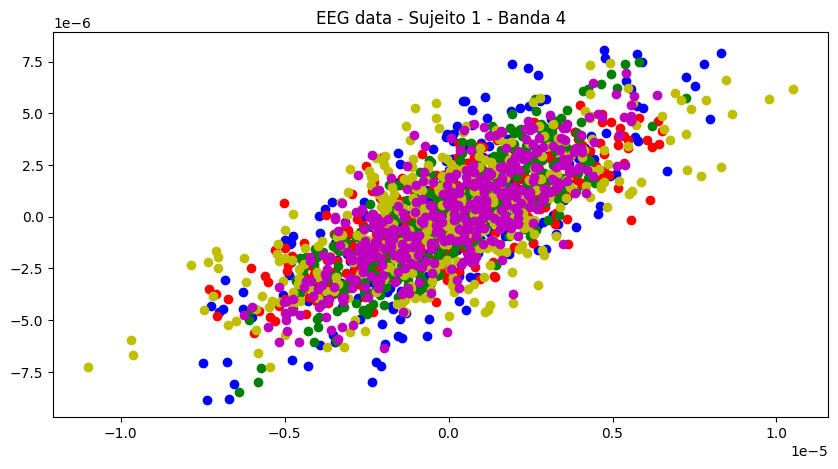

Banda:  5


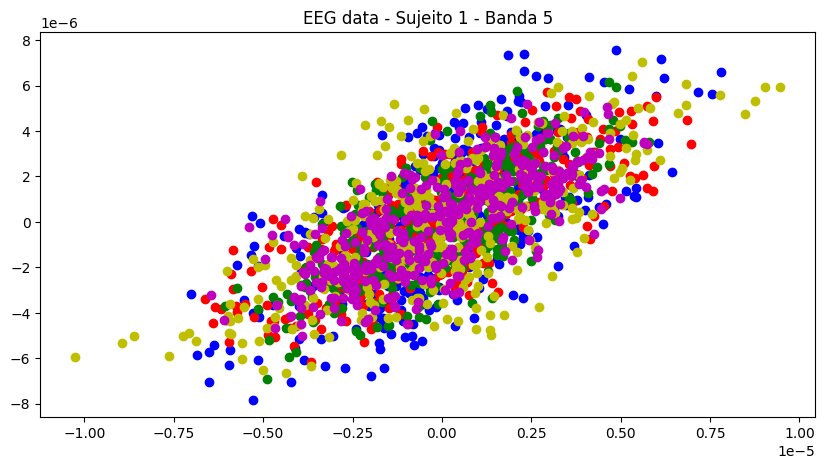

Banda:  6


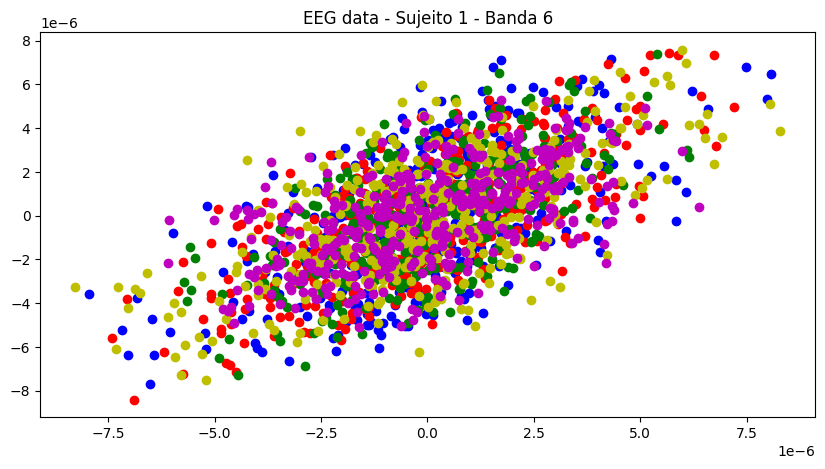

Banda:  7


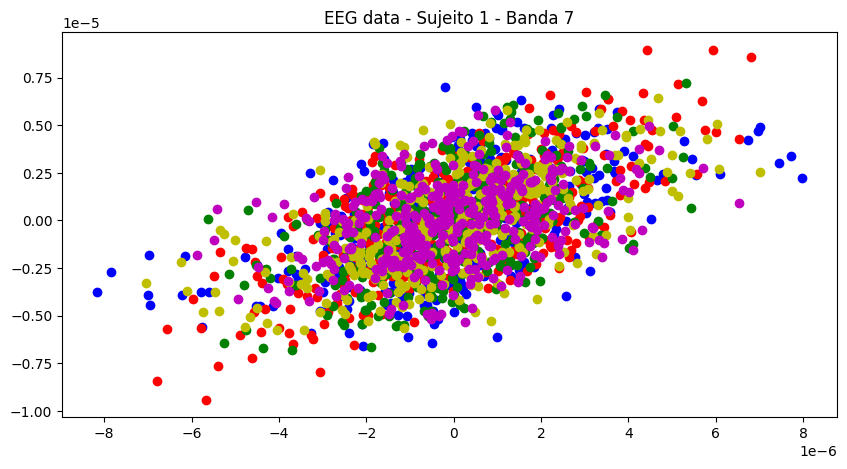

Banda:  8


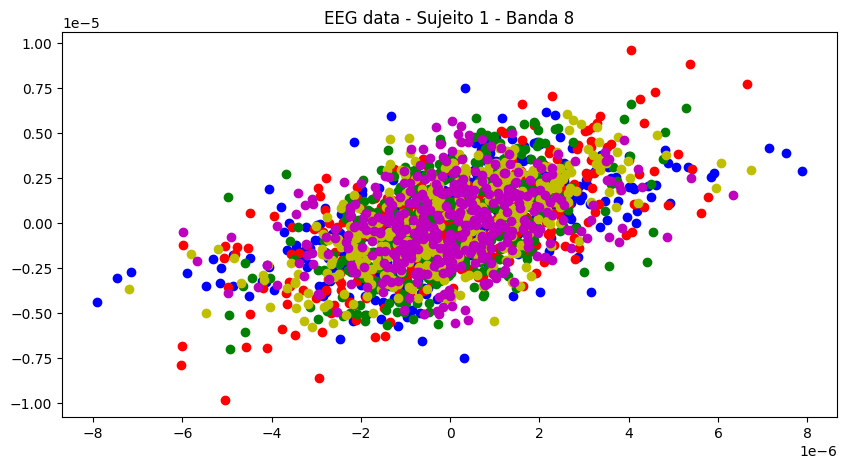

Banda:  9


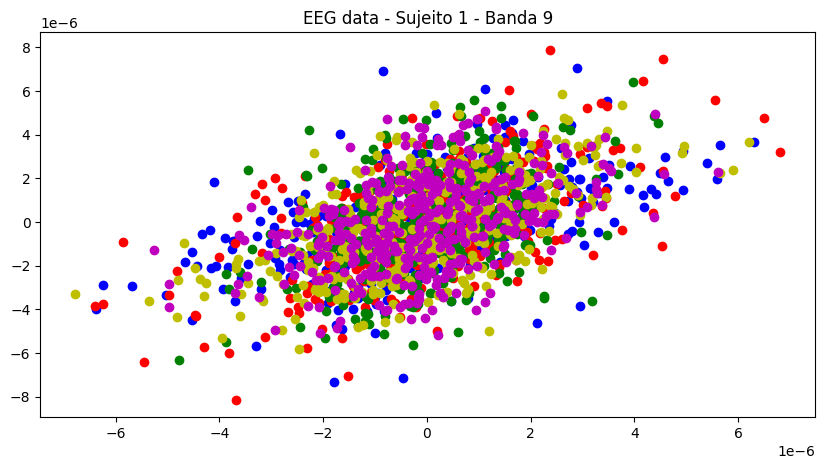

Banda:  10


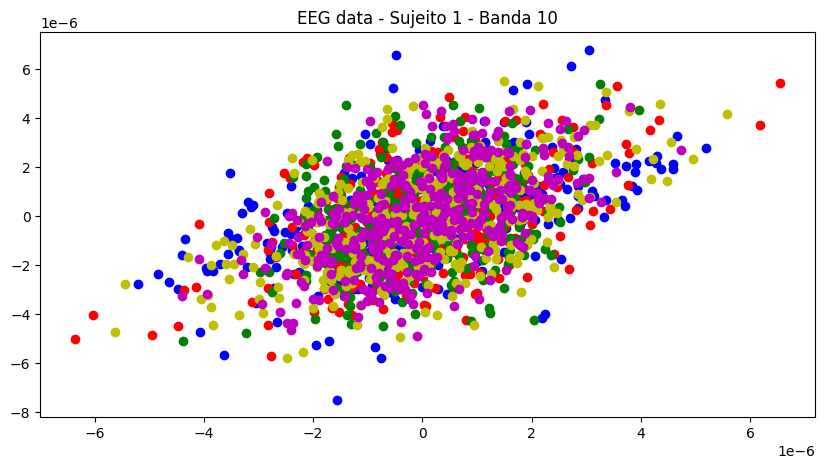

Banda:  11


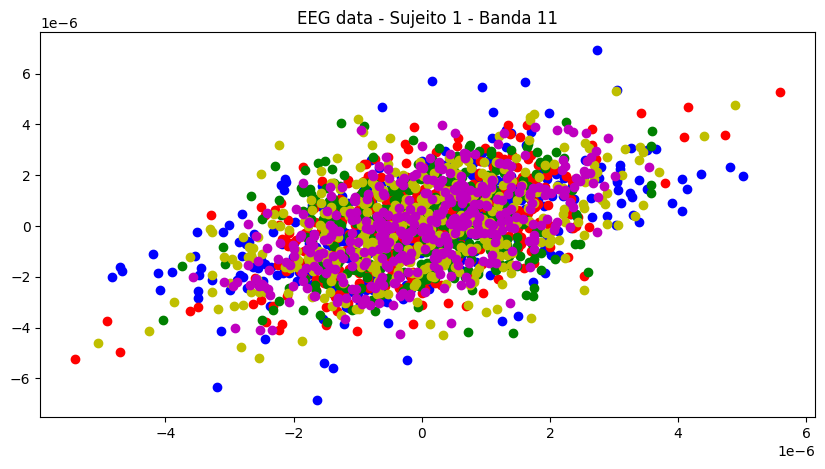

Banda:  12


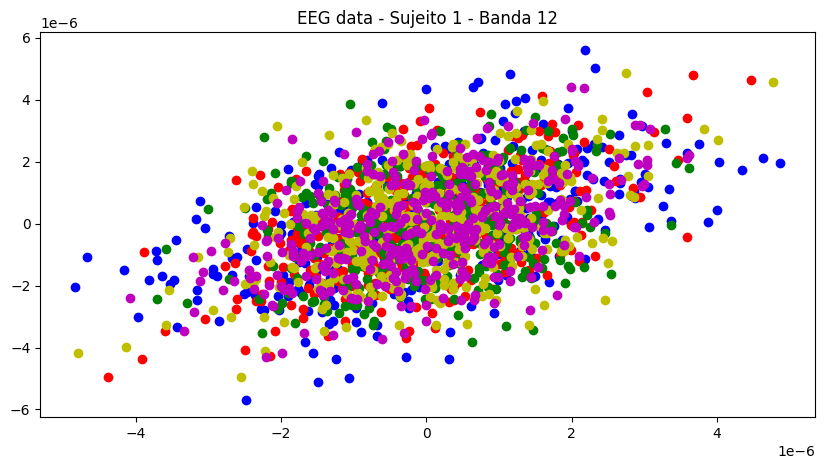

Banda:  13


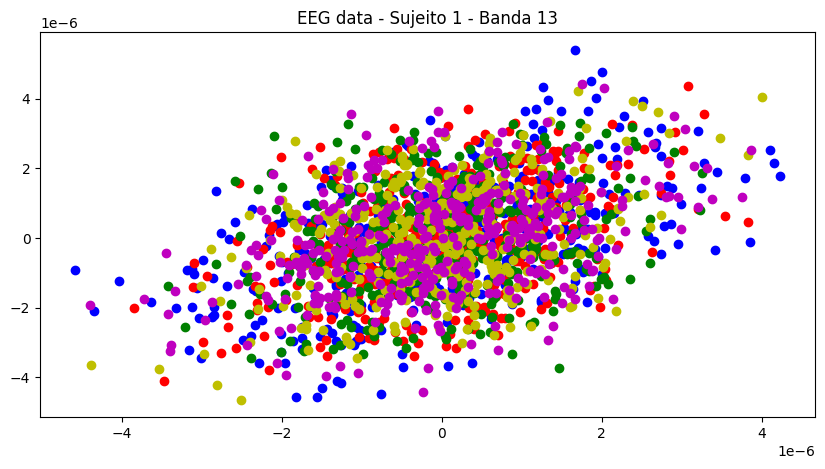

Banda:  14


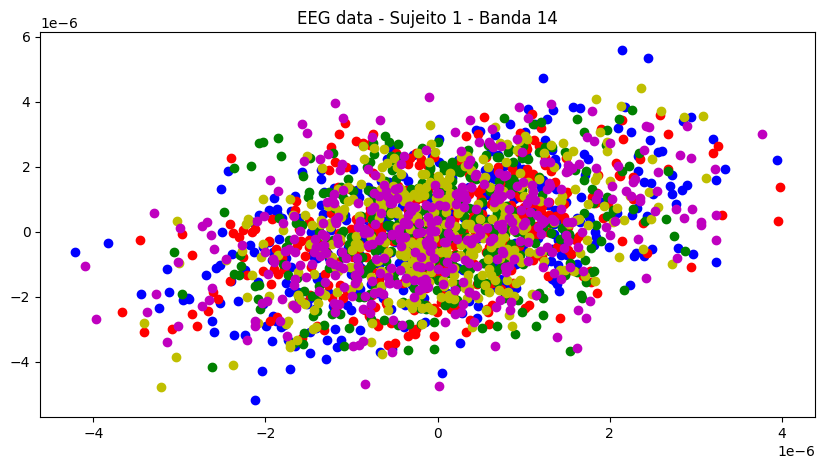

Banda:  15


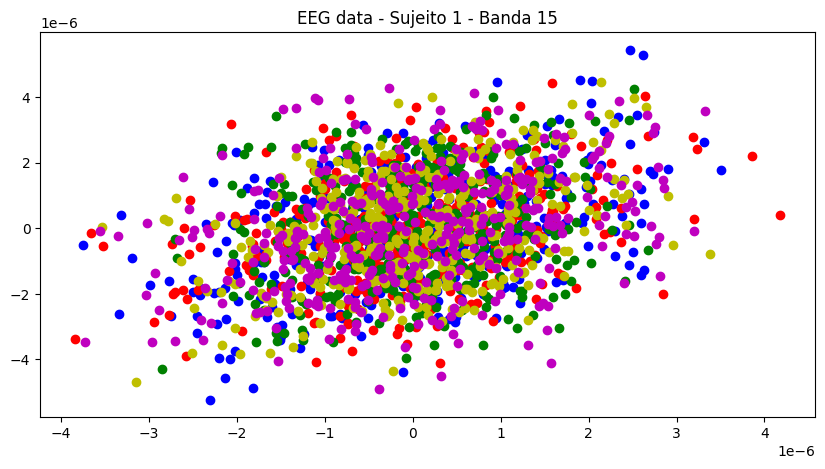

Banda:  16


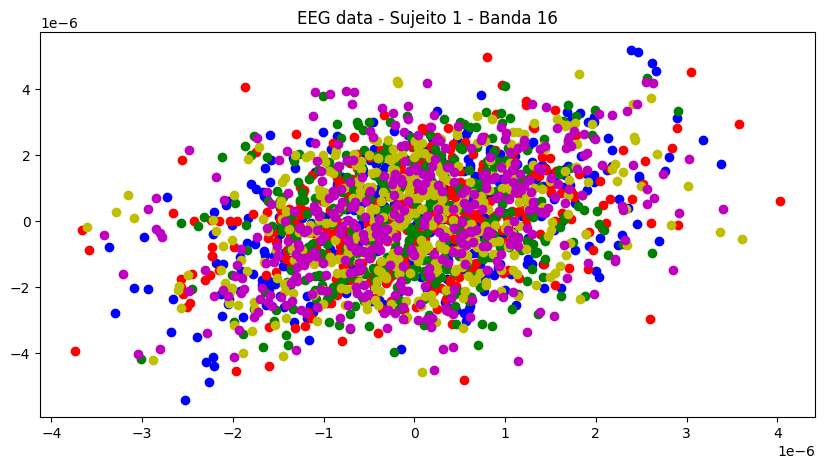

Banda:  17


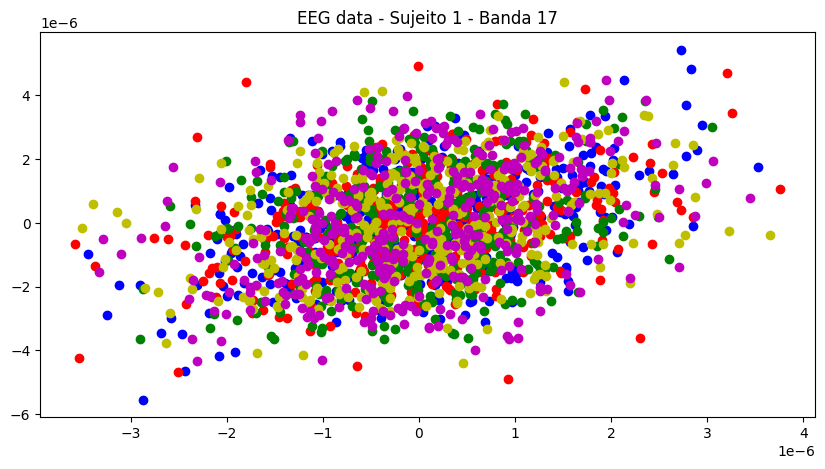

In [22]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g', 'y', 'm']

subject = 0
print("Sujeito: ", subject+1)

for band in range(len(bands)):
    print("Banda: ", band+1)
    plt.figure(figsize=(10, 5))
    for class_ in range(5):
        # for i in range(all_train_data[subject][band][0][0].shape[0]): 
        #     plt.plot(all_train_data[subject][band][0][0][i])
        plt.scatter(all_train_data[subject][band][class_][0][0], all_train_data[subject][band][class_][0][2], color = colors[class_])
    plt.title(f"EEG data - Sujeito {subject+1} - Banda {band+1}")
    plt.show()



In [23]:
def train_CSP(X, Y, num_filters):
    X -= np.mean(X, axis=2)[:, :, np.newaxis]

    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]

    d, V = la.eigh(S0, S0 + S1)

    # get order of eigenvalues
    idx = np.argsort(np.abs(d - 0.5))[::-1]

    # reorder the eigenvectors
    V = V[:, idx]

    # transpose
    W = V.T

    # compute the patterns
    pattern = np.linalg.pinv(V)

    #select the two most important filters
    W = W[: num_filters]

    return W


def apply_csp(X, W, mean_power=False):
    X_csp = np.asarray([np.dot(W, epoch) for epoch in X])
    if mean_power:
        X_csp = (X_csp**2).mean(axis=2)
    
    return X_csp

In [24]:
def get_filters(X_input, y, J=6):
    filters = []

    for chosen_band in range(len(bands)):
        band_filters = []
        for chosen_class in range(5):
            X = X_input[chosen_band]
            X = X.reshape(-1, X.shape[2], X.shape[3])

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

            y_train = (y_train == chosen_class).astype(int)
            y_test = (y_test == chosen_class).astype(int)

            W = train_CSP(X_train, y_train, J)

            band_filters.append(W)
        filters.append(band_filters)

    return filters

In [25]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

def get_top_bands(X, filters, n_top_bands):
    all_class_filters = []

    for chosen_class in range(5):
        all_filters = []

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        X_test = X_test.transpose(1, 0, 2, 3)

        X_train = X_train.transpose(1, 2, 3, 0)
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2] * X_train.shape[3])

        for band in range(len(bands)):
            for filter in range(len(filters[band])):
                X_csp = X_train[band]
                X_csp = apply_csp(X_train[band], filters[filter][chosen_class])
                all_filters.append(X_csp[0])

        all_filters = np.array(all_filters)
        all_filters = all_filters.transpose(0, 2, 1).reshape(all_filters.shape[0], all_filters.shape[2] * all_filters.shape[1])
        clustering = AffinityPropagation(random_state = 5).fit(all_filters)
        #clustering = KMeans(n_clusters=8, random_state=0).fit(all_filters)
        #print(chosen_class, "LEN", len(clustering.cluster_centers_))

        # Ele escolheu os centros (que fazem parte do all_filters que lhe demos), agora  é preciso identificar qual é qual 

        selected_filters = []
        for center in clustering.cluster_centers_:
            min_dist = float('inf')
            selected_filter = 0
            for i, filter in enumerate(all_filters):
                dist = np.linalg.norm(center - filter)
                if dist < min_dist:
                    min_dist = dist
                    selected_filter = i
            selected_filters.append(selected_filter)

        selected_filters = [[(f//len(filters[band])), (f%len(filters[band]))] for f in selected_filters]
        selected_filters = np.array(selected_filters)
        all_class_filters.append(selected_filters)

    band_counters = np.zeros((len(bands), 5))

    for class_ in range(5):
        for band, filter in all_class_filters[class_]:
            band_counters[band, class_] += 1

    band_counters_ranked = np.sum(band_counters, axis=1)

    plt.plot(band_counters_ranked)
    plt.show()

    return np.argsort(band_counters_ranked)[::-1][:n_top_bands]

The bands and number of features were chosen based on the bands that resulted in less redundant information. These were determined using Affinity Propagation and K_means.

After experimenting, we concluded that band 5 was crucial, and bands 9,12,13,14 were very important, but somewhat redundant among themselves.

After trying various classifiers, we came to the conclusion that the best was the Support Vector Machine with "poly" kernel. Although some Multi-Layered Perceptron architectures achieved simmalar results, these were always in a simmilar same range as the Support Vector Machine, never better. The SVM is a simpler model and as such is prefered, when the accuracy is the same.

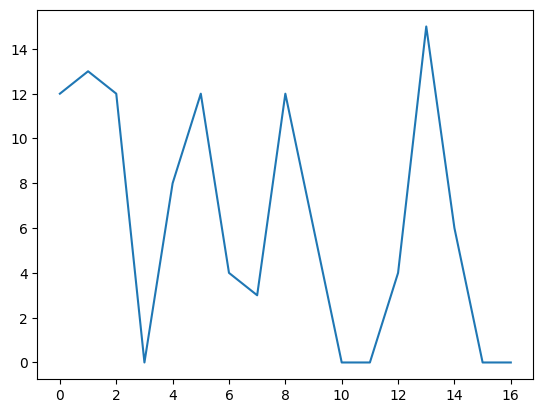

Chosen Bands: [13  1  8]


 rbf
[0.5        0.50095238]
mean 0.5004761904761905


 linear
[0.5        0.55809524]
mean 0.529047619047619


 poly
[0.43333333 0.54      ]
mean 0.4866666666666667


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  linear
Shapes:  (45, 17, 16, 401) (45,)
(45, 17, 16, 401) (45,)
Balanced accuracy:  0.4666666666666667


f:\OneDrive\Ambiente de Trabalho\neuro\eegaming\env\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


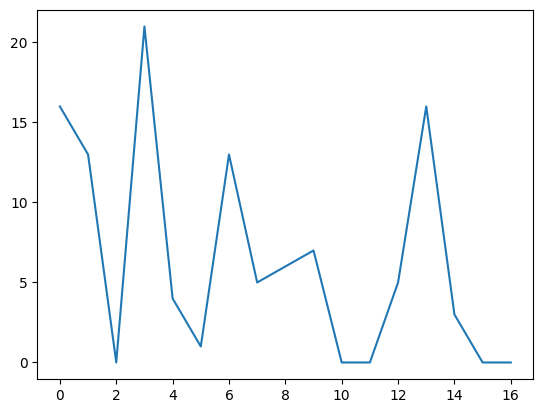

Chosen Bands: [ 3  0 13]


 rbf
[0.43333333 0.52285714]
mean 0.47809523809523813


 linear
[0.75       0.79142857]
mean 0.7707142857142857


 poly
[0.75       0.64285714]
mean 0.6964285714285714


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  linear
Shapes:  (45, 17, 16, 401) (45,)
(45, 17, 16, 401) (45,)
Balanced accuracy:  0.7555555555555554


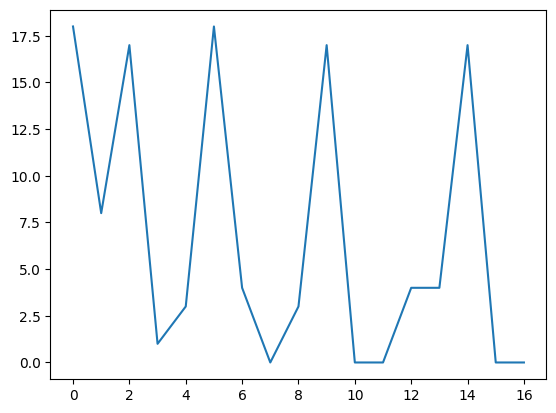

Chosen Bands: [ 0  5 14]


 rbf
[0.4        0.45714286]
mean 0.4285714285714286


 linear
[0.5  0.44]
mean 0.47000000000000003


 poly
[0.4        0.41142857]
mean 0.40571428571428575


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  linear
Shapes:  (45, 17, 16, 401) (45,)
(45, 17, 16, 401) (45,)
Balanced accuracy:  0.4888888888888888


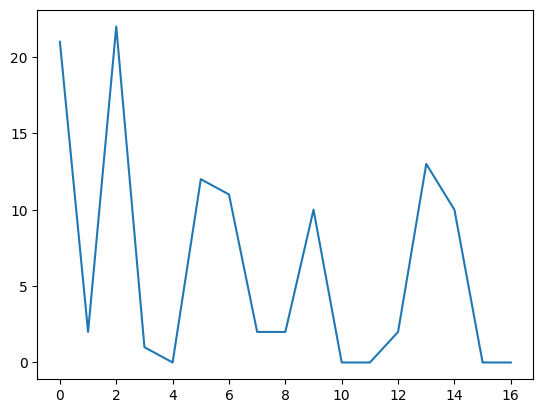

Chosen Bands: [ 2  0 13]


 rbf
[0.4        0.37333333]
mean 0.3866666666666667


 linear
[0.46666667 0.47904762]
mean 0.47285714285714286


 poly
[0.46666667 0.51904762]
mean 0.49285714285714277


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  poly
Shapes:  (45, 17, 16, 401) (45,)
(45, 17, 16, 401) (45,)
Balanced accuracy:  0.35555555555555557


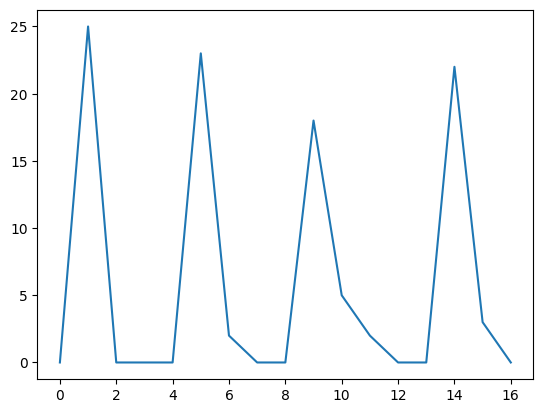

Chosen Bands: [ 1  5 14]


 rbf
[0.46666667 0.31428571]
mean 0.3904761904761904


 linear
[0.35       0.39285714]
mean 0.37142857142857144


 poly
[0.31666667 0.38142857]
mean 0.34904761904761905


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  rbf
Shapes:  (45, 17, 16, 401) (45,)
(45, 17, 16, 401) (45,)
Balanced accuracy:  0.4888888888888888


In [26]:
def train_classifier(X, y, chosen_bands, J):
    kernel_type = ["rbf", "linear", "poly", "sigmoid"]
    models = []
    input_signal = []
    score_list = []
    filter_banks = []
    

    for band in chosen_bands:
        signal = X[:, band, :, :]

        #trian test split
        X_train, X_test, y_train, y_test = train_test_split(signal, y, test_size=0.3, random_state=42)


        W_bank = []
        for i in range(5):
            W = train_CSP(X_train, 1.*(y_train==i), J)
            W_bank.append(W)
        filter_banks.append(W_bank)
        

        for W in W_bank:
            X_csp = apply_csp(X_test, W)
            energy = np.log(np.std(X_csp, axis=2))
            # energy = np.std(X_csp, axis=2)
            input_signal.append(energy)


    input_signal = np.array(input_signal)
    input_signal = input_signal.transpose(1, 0, 2)
    input_signal = input_signal.reshape(input_signal.shape[0], input_signal.shape[1]*input_signal.shape[2])


    #train lda
    for k in kernel_type:
        clf = SVC(kernel=k)
        print("\n\n", k)
        scores = cross_val_score(clf, input_signal, y_test, cv=2, scoring='balanced_accuracy')
        print(scores)
        print("mean", np.mean(scores))
        #print("std", np.std(scores))
        score_list.append(np.mean(scores))
        clf.fit(input_signal, y_test)
        models.append(clf)

    best_kernel = kernel_type[np.argmax(score_list)]
    print("Best kernel: ", best_kernel)

    return models[np.argmax(score_list)], filter_banks, np.max(score_list)
    
def preprocess(X, chosen_bands, filter_banks):
    input_signal = []


    for idx, band in enumerate(chosen_bands):
        signal = X[:, band, :, :]

        for W in filter_banks[idx]:
            X_csp = apply_csp(signal, W)
            energy = np.log(np.std(X_csp, axis=2))
            # energy = np.std(X_csp, axis=2)
            input_signal.append(energy)


    input_signal = np.array(input_signal)
    input_signal = input_signal.transpose(1, 0, 2)
    input_signal = input_signal.reshape(input_signal.shape[0], input_signal.shape[1]*input_signal.shape[2])

    return input_signal


def classify(X_processed, model):
    return model.predict(X_processed)

def inference(X, chosen_bands, filter_banks, model):
    X_processed = preprocess(X, chosen_bands, filter_banks)
    return classify(X_processed, model)


mean_values_over_all_subjects = []

for subject in range(len(all_train_data)):
    X = np.array(all_train_data[subject])
    y = np.zeros(X.shape[1]* X.shape[2])
    for class_ in range(X.shape[1]):
        y[class_ * X.shape[2]: (class_ + 1) * X.shape[2]] = class_

    filters = get_filters(X, y)

    X = X.transpose(1, 2, 0, 3, 4)
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

    n_features = 3
    J = 6

    chosen_bands = get_top_bands(X, filters, n_features)

    print("Chosen Bands:", chosen_bands)

    model, filter_banks, validation_acc = train_classifier(X, y, chosen_bands, J)

    #test with X and y
    X_test = np.array(all_test_data[subject])
    X_test = X_test.transpose(1, 2, 0, 3, 4)
    X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[4])

    y_test = np.zeros(X_test.shape[0])
    for i in range(5):
        y_test[i*X_test.shape[0]//5:(i+1)*X_test.shape[0]//5] = i

    print("Shapes: ", X_test.shape, y_test.shape)

    print(X_test.shape, y_test.shape)

    y_pred = inference(X_test, chosen_bands, filter_banks, model)
    print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

    mean_values_over_all_subjects.append([balanced_accuracy_score(y_test, y_pred), validation_acc])

mean_values_over_all_subjects = np.array(mean_values_over_all_subjects)

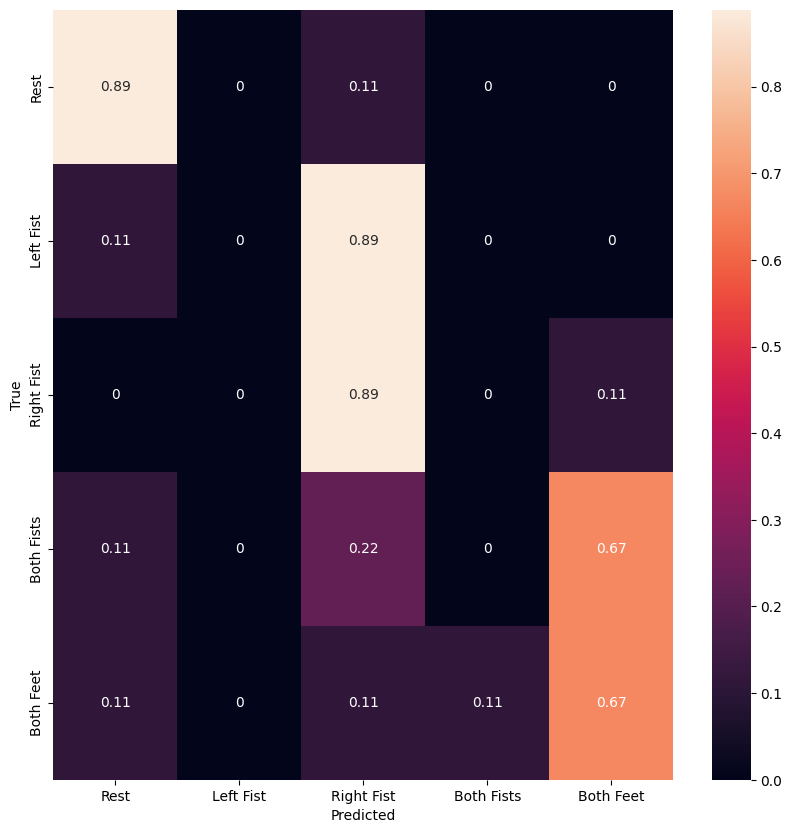

Mean values over all subjects:  [[0.46666667 0.52904762]
 [0.75555556 0.77071429]
 [0.48888889 0.47      ]
 [0.35555556 0.49285714]
 [0.48888889 0.39047619]]
Mean:  [0.51111111 0.53061905]
Std:  [0.13184353 0.12836576]


In [27]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred, ['Rest', 'Left Fist', 'Right Fist', 'Both Fists', 'Both Feet'])

print("Mean values over all subjects: ", mean_values_over_all_subjects)
print("Mean: ", np.mean(mean_values_over_all_subjects, axis=0))
print("Std: ", np.std(mean_values_over_all_subjects, axis=0))



Computing the accuracies for all of the subjects takes more than 40GB of RAM and many hours. So we computed it in parts and gathered all the results below.

In [28]:
mean_values_over_all_subjects = [[0.6,0.58190476],
[0.37777778,0.37857143],
[0.31111111,0.44309524],
[0.66666667,0.47761905],
[0.35555556,0.45285714],
[0.42222222,0.29428571],
[0.73333333,0.58],
[0.57777778,0.53619048],
[0.33333333,0.38452381],
[0.475,0.3202381],
[0.35555556,0.38047619],
[0.53333333,0.54571429],
[0.62222222,0.26857143],
[0.4,0.40857143],
[0.55555556,0.56238095],
[0.37777778,0.4052381],
[0.4,0.43142857],
[0.46666667,0.41761905],
[0.2,0.2],
[0.46666667,0.26095238],
[0.5,0.34642857],
[0.51111111,0.33119048],
[0.35555556,0.31857143],
[0.64444444,0.5747619],
[0.48888889,0.46238095],
[0.55555556,0.42119048],
[0.46666667,0.48666667],
[0.42222222,0.39238095],
[0.84444444,0.53380952],
[0.35555556,0.4652381],
[0.48888889,0.45809524],
[0.57777778,0.60809524],
[0.46666667,0.4347619],
[0.51111111,0.45571429],
[0.6,0.51642857],
[0.44444444,0.55714286],
[0.26666667,0.32428571],
[0.2,0.41285714],
[0.35555556,0.26380952],
[0.33333333,0.29190476],
[0.46666667,0.52904762],
[0.75555556,0.77071429],
[0.48888889,0.47],
[0.35555556,0.49285714],
[0.48888889,0.39047619],
[0.53333333,0.46285714],
[0.37777778,0.25619048],
[0.57777778,0.47952381],
[0.66666667,0.56833333],
[0.42222222,0.3247619],
[0.48888889,0.41904762],
[0.53333333,0.49142857],
[0.48888889,0.51619048],
[0.66666667,0.48380952],
[0.62222222,0.50714286],
[0.6,0.61047619],
[0.425,0.49857143],
[0.51111111,0.48666667],
[0.28888889,0.33857143],
[0.37777778,0.49857143],
[0.53333333,0.37309524],
[0.48888889,0.46666667],
[0.37777778,0.29095238],
[0.37777778,0.23714286],
[0.31111111,0.3852381],
[0.28888889,0.31952381],
[0.35555556,0.33714286],
[0.46666667,0.45952381],
[0.42222222,0.415],
[0.33333333,0.42809524],
[0.4,0.35904762],
[0.55555556,0.50857143],
[0.46666667,0.44190476],
[0.2,0.25619048],
[0.24444444,0.25857143],
[0.37777778,0.47714286],
[0.425,0.3797619],
[0.22222222,0.23714286],
[0.37777778,0.33952381],
[0.37777778,0.52285714],
[0.46666667,0.37047619],
[0.3,0.33238095],
[0.37777778,0.43428571],
[0.37777778,0.33095238],
[0.37777778,0.38285714],
[0.55555556,0.5347619],
[0.24444444,0.35404762],
[0.23636364,0.31916667],
[0.64444444,0.43190476],
[0.33333333,0.45047619],
[0.46666667,0.61047619],
[0.36363636,0.48619048],
[0.48888889,0.40095238],
[0.64444444,0.61047619],
[0.33333333,0.41214286],
[0.24444444,0.36285714],
[0.37777778,0.27095238],
[0.42222222,0.45761905],
[0.2,0.2],
[0.6,0.46833333],
[0.33333333,0.40761905],
[0.51111111,0.51142857],
[0.57777778,0.4647619],
[0.53333333,0.36071429],
[0.44444444,0.5047619],
[0.2,0.24333333],
[0.2,0.2652381],
[0.26666667,0.36190476],
[0.28888889,0.29190476]]

mean_values_over_all_subjects = np.array(mean_values_over_all_subjects)

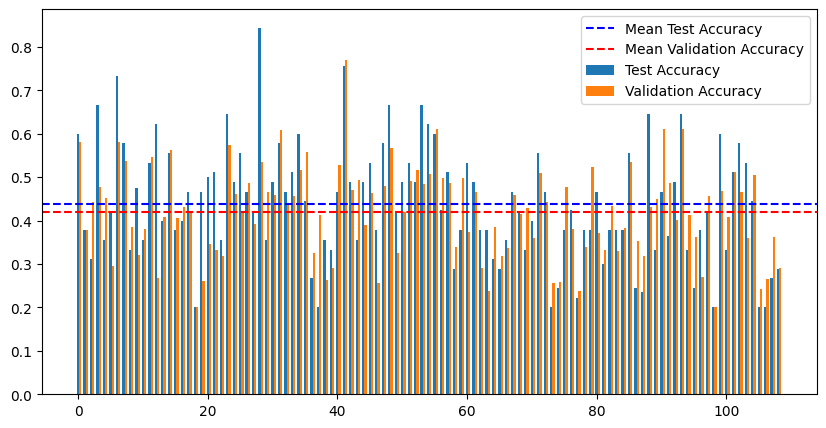

Mean Test Accuracy:  0.43825178431192663
Mean Validation Accuracy:  0.41933267816513753


<Figure size 1000x500 with 0 Axes>

In [29]:
bar_width = 0.35
index = np.arange(len(mean_values_over_all_subjects))

plt.figure(figsize=(10, 5))
plt.bar(index, mean_values_over_all_subjects[:, 0], bar_width)
plt.bar(index + bar_width, mean_values_over_all_subjects[:, 1], bar_width)
plt.axhline(y=np.mean(mean_values_over_all_subjects[:, 0]), color='b', linestyle='--')
plt.axhline(y=np.mean(mean_values_over_all_subjects[:, 1]), color='r', linestyle='--')
plt.legend(["Mean Test Accuracy", "Mean Validation Accuracy", "Test Accuracy", "Validation Accuracy"])
plt.show()

print("Mean Test Accuracy: ", np.mean(mean_values_over_all_subjects[:, 0]))
print("Mean Validation Accuracy: ", np.mean(mean_values_over_all_subjects[:, 1]))

plt.figure(figsize=(10, 5))
plt.show()

In [30]:
print(mean_values_over_all_subjects)

[[0.6        0.58190476]
 [0.37777778 0.37857143]
 [0.31111111 0.44309524]
 [0.66666667 0.47761905]
 [0.35555556 0.45285714]
 [0.42222222 0.29428571]
 [0.73333333 0.58      ]
 [0.57777778 0.53619048]
 [0.33333333 0.38452381]
 [0.475      0.3202381 ]
 [0.35555556 0.38047619]
 [0.53333333 0.54571429]
 [0.62222222 0.26857143]
 [0.4        0.40857143]
 [0.55555556 0.56238095]
 [0.37777778 0.4052381 ]
 [0.4        0.43142857]
 [0.46666667 0.41761905]
 [0.2        0.2       ]
 [0.46666667 0.26095238]
 [0.5        0.34642857]
 [0.51111111 0.33119048]
 [0.35555556 0.31857143]
 [0.64444444 0.5747619 ]
 [0.48888889 0.46238095]
 [0.55555556 0.42119048]
 [0.46666667 0.48666667]
 [0.42222222 0.39238095]
 [0.84444444 0.53380952]
 [0.35555556 0.4652381 ]
 [0.48888889 0.45809524]
 [0.57777778 0.60809524]
 [0.46666667 0.4347619 ]
 [0.51111111 0.45571429]
 [0.6        0.51642857]
 [0.44444444 0.55714286]
 [0.26666667 0.32428571]
 [0.2        0.41285714]
 [0.35555556 0.26380952]
 [0.33333333 0.29190476]
